# WCGS Description

The Western Collaborative Group Study (WCGS) was designed to test the hypothesis that the so-called Type A behavior pattern (TABP) - “characterized particularly by excessive drive, aggressiveness, and ambition, frequently in association with a relatively greater preoccupation with competitive activity, vocational deadlines, and similar pressures” - is a cause of coronary heart disease (CHD). Two additional goals, developed later in the study, were (1) to investigate the comparability of formulas developed in WCGS and in the Framingham Study (FS) for prediction of CHD risk, and (2) to determine how addition of TABP to an existing multivariate prediction formula affects ability to select subjects for intervention programs.

The study enrolled over 3,000 men ages 39-59 who were employed in San Francisco or Los Angeles, during 1960 and 1961.

- `id`: ID
- `age`: age, in years - no decimal places
- `height`: height, in inches
- `weight`: weight, in pounds
- `sbp`: systolic blood pressure, in mmHg
- `dbp`: diastolic blood pressure, mmHg
- `chol`: total cholesterol, mg/dL
- `behpat`: behavioral pattern: 1, 2, 3, 4
- `nicgs`: number of cigarettes smoked per day
- `dibpat`: behavioral pattern: A or B
- `chd69`: CHD event: Yes or No
- `typechd`: event: 0 = no CHD, 1 = MI or SD, 2 = silent MI, 3 = angina
- `time169`: follow-up time in days
- `arcus`: arcus senilis present (1) or absent (0)

### Problems to solve:
__Descriptive Statistics__

1. Describe variables: age, cholesterol, number of cigarettes smoked per day, coronary heart disease, behavioral pattern, A - behavioral pattern, arcus
2. Correlation between cholesterol and CHD
3. Correlation between BMI and cholesterol
4. Correlation between hypertension (sbp $\geq$ 140mmHg or dbp $\geq$ 90mmHg) and CHD

__Predictive Model__
1. Predict CHD event

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wcgs-data/datawcgs.csv


In [2]:
%pip install "setuptools<58.0"
%pip install regressors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.8.0
    Uninstalling setuptools-59.8.0:
      Successfully uninstalled setuptools-59.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
opentelemetry-api 1.17.0 requires importlib-metadata~=6.0.0, but you have importlib-metadata 5.2.0 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... - \ done
  Created wheel for regressors: filename=regressors-0.0.3-py

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import regressors.stats as regstats

%matplotlib inline

In [4]:
df = pd.read_csv("/kaggle/input/wcgs-data/datawcgs.csv")
df = df.drop("Unnamed: 0", axis = 1)

In [5]:
df.head()

,id,age0,height0,weight0,sbp0,dbp0,chol0,behpat0,ncigs0,dibpat0,chd69,typechd,time169,arcus0
0,2001,49,73,150,110,76,225.0,2,25,1,0,0,1664,0.0
1,2002,42,70,160,154,84,177.0,2,20,1,0,0,3071,1.0
2,2003,42,69,160,110,78,181.0,3,0,0,0,0,3071,0.0
3,2004,41,68,152,124,78,132.0,4,20,0,0,0,3064,0.0
4,2005,59,70,150,144,86,255.0,3,20,0,1,1,1885,1.0


# Look through the data

In [6]:
df.columns

Index(['id', 'age0', 'height0', 'weight0', 'sbp0', 'dbp0', 'chol0', 'behpat0',
       'ncigs0', 'dibpat0', 'chd69', 'typechd', 'time169', 'arcus0'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3154 entries, 0 to 3153
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3154 non-null   int64  
 1   age0     3154 non-null   int64  
 2   height0  3154 non-null   int64  
 3   weight0  3154 non-null   int64  
 4   sbp0     3154 non-null   int64  
 5   dbp0     3154 non-null   int64  
 6   chol0    3142 non-null   float64
 7   behpat0  3154 non-null   int64  
 8   ncigs0   3154 non-null   int64  
 9   dibpat0  3154 non-null   int64  
 10  chd69    3154 non-null   int64  
 11  typechd  3154 non-null   int64  
 12  time169  3154 non-null   int64  
 13  arcus0   3152 non-null   float64
dtypes: float64(2), int64(12)
memory usage: 345.1 KB


In [8]:
df.isnull().sum() /  df.shape[0]

id         0.000000
age0       0.000000
height0    0.000000
weight0    0.000000
sbp0       0.000000
dbp0       0.000000
chol0      0.003805
behpat0    0.000000
ncigs0     0.000000
dibpat0    0.000000
chd69      0.000000
typechd    0.000000
time169    0.000000
arcus0     0.000634
dtype: float64

Filling null value in `chol0` and drop `arcus0` null rows

In [9]:
df = df.dropna(subset = 'arcus0')
df['chol0'] = df['chol0'].fillna(df['chol0'].mean())
df.isnull().sum()

id         0
age0       0
height0    0
weight0    0
sbp0       0
dbp0       0
chol0      0
behpat0    0
ncigs0     0
dibpat0    0
chd69      0
typechd    0
time169    0
arcus0     0
dtype: int64

In [10]:
df['chol0'] = df['chol0'].astype(float)

In [11]:
df.head()

,id,age0,height0,weight0,sbp0,dbp0,chol0,behpat0,ncigs0,dibpat0,chd69,typechd,time169,arcus0
0,2001,49,73,150,110,76,225.0,2,25,1,0,0,1664,0.0
1,2002,42,70,160,154,84,177.0,2,20,1,0,0,3071,1.0
2,2003,42,69,160,110,78,181.0,3,0,0,0,0,3071,0.0
3,2004,41,68,152,124,78,132.0,4,20,0,0,0,3064,0.0
4,2005,59,70,150,144,86,255.0,3,20,0,1,1,1885,1.0


## Convert weight and height to kg and cm

In [12]:
df['height0'] = np.round(df['height0']*2.54, 2)
df['weight0'] = np.round(df['weight0']*0.454, 2)

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3152.0,10479.727157,5877.192558,2001.00,3741.75,11405.50,13114.25,22101.00
age0,3152.0,46.278553,5.522564,39.00,42.00,45.00,50.00,59.00
height0,3152.0,177.231079,6.422476,152.40,172.72,177.80,182.88,198.12
weight0,3152.0,77.158798,9.580260,35.41,70.37,77.18,82.63,145.28
sbp0,3152.0,128.626904,15.120601,98.00,120.00,126.00,136.00,230.00
dbp0,3152.0,82.007931,9.725147,58.00,76.00,80.00,86.00,150.00
chol0,3152.0,226.345541,43.338322,103.00,198.00,223.00,252.00,645.00
behpat0,3152.0,2.523160,0.799141,1.00,2.00,2.00,3.00,4.00
ncigs0,3152.0,11.602792,14.520504,0.00,0.00,0.00,20.00,99.00
dibpat0,3152.0,0.503807,0.500065,0.00,0.00,1.00,1.00,1.00


The height is around its mean value (177.23cm) with a slight variance (6cm) indicating the fact that there is a huge range in western resident's heights. In constrast, a significantly large variance observed in their weight, which ranges from 35.41kg to 145.28kg with standard variation just under 10kg. Interestingly, the follow-up time for each subject seems to randomly fluctuate since the number of days goes from 18 days to approximately 10 years

## Correlation in numerical features

In [14]:
numerical_features = ['age0', 'weight0', 'sbp0', 'dbp0', 'chol0', 'ncigs0', 'time169']
numerical_df = df[numerical_features]

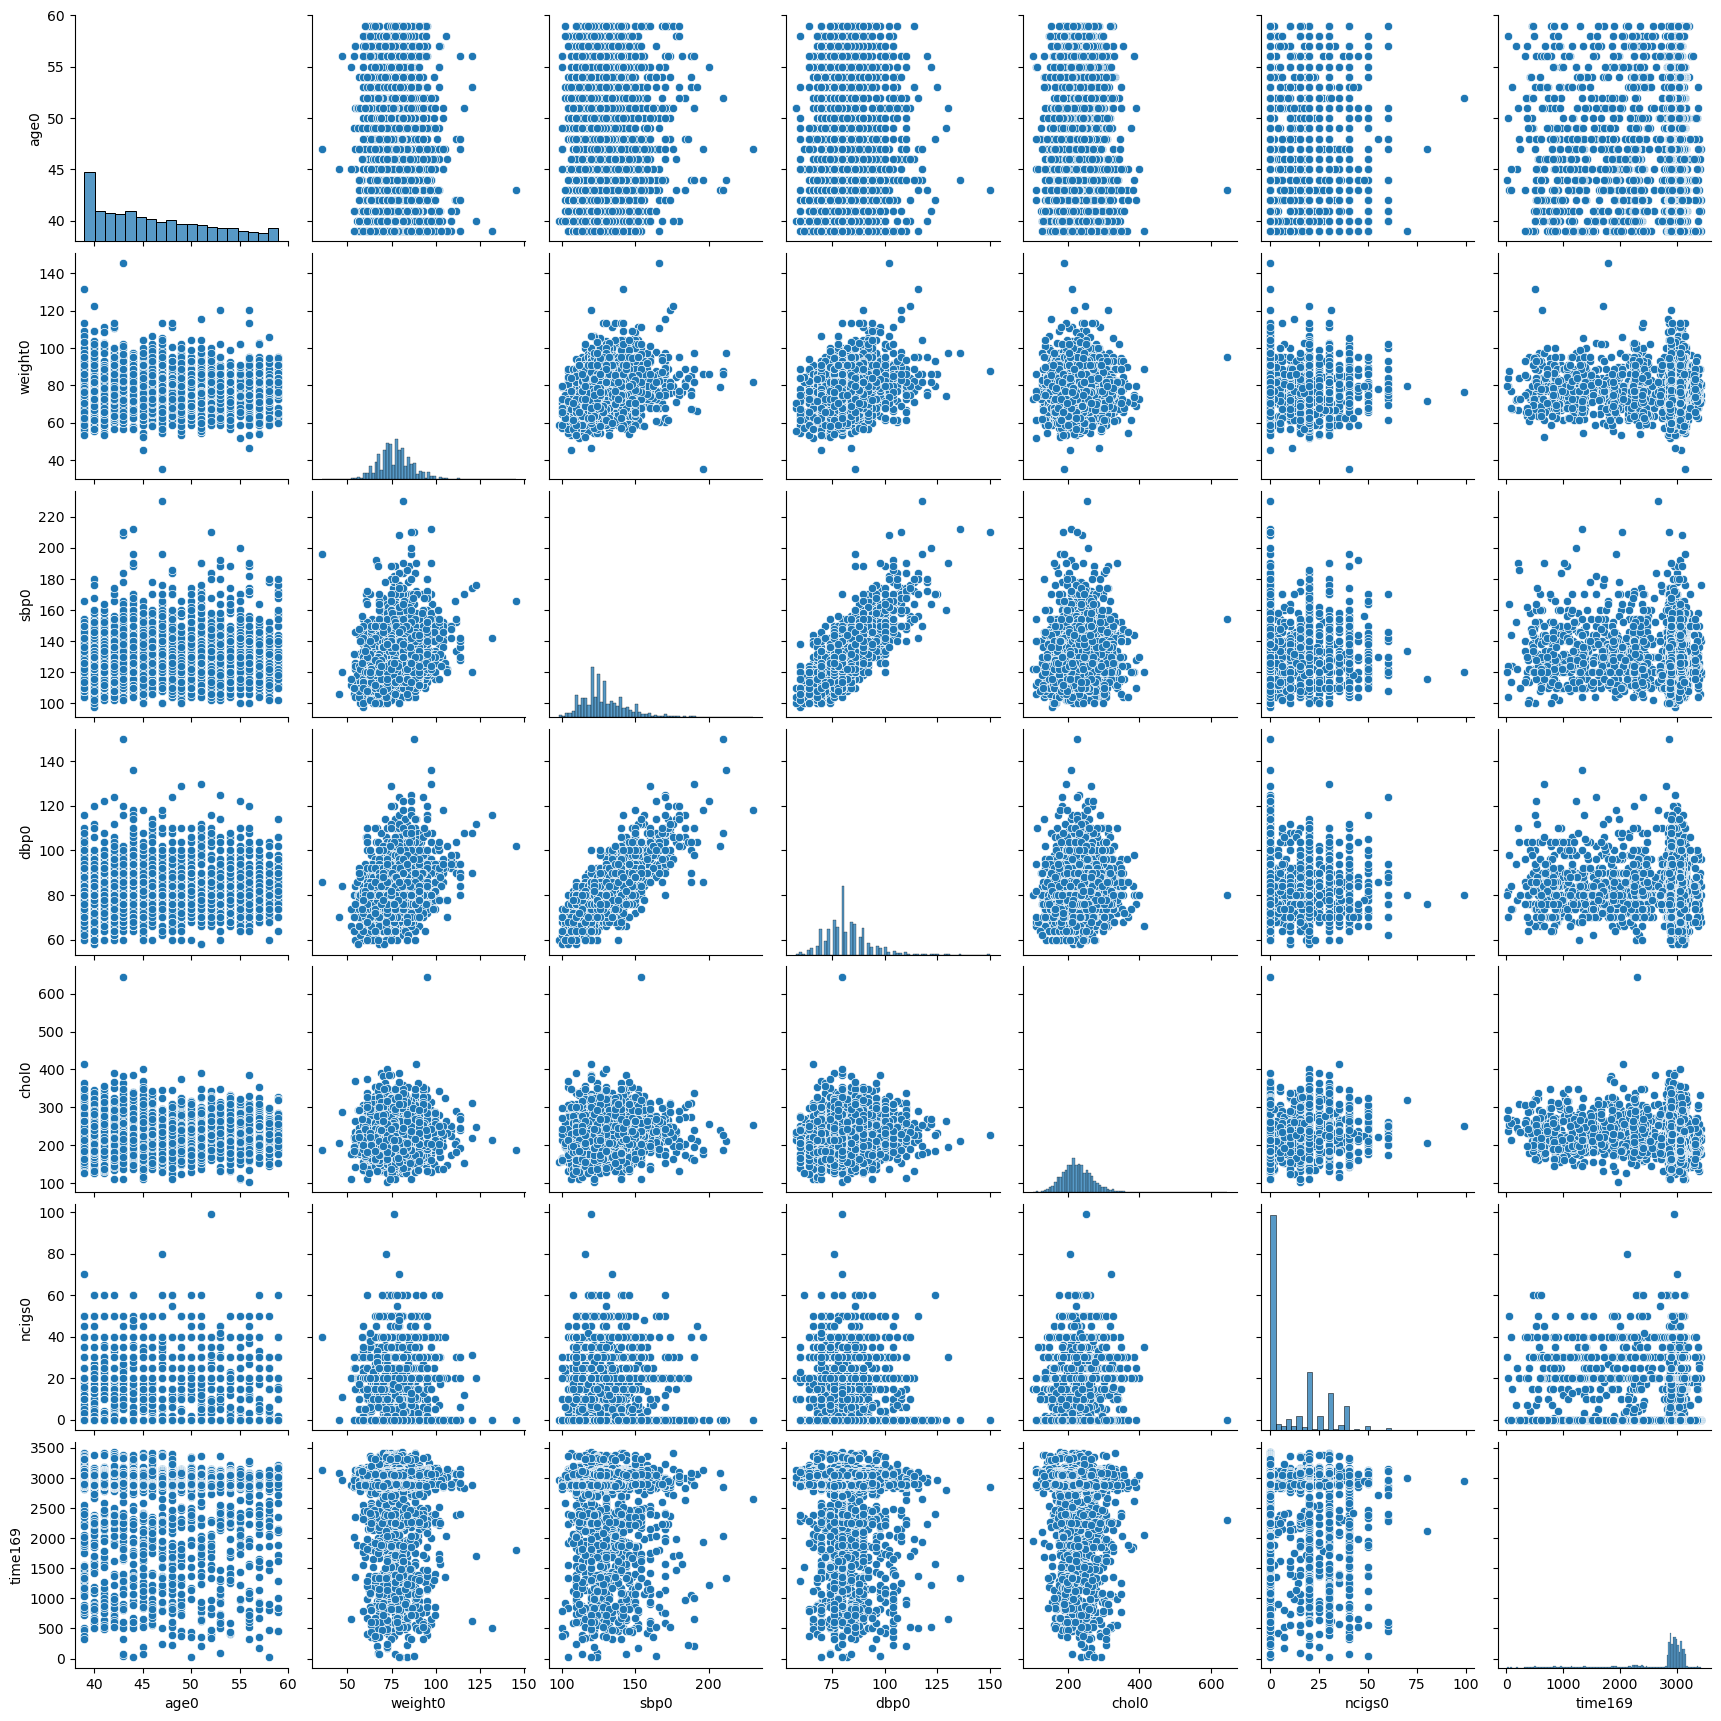

In [15]:
sns.pairplot(numerical_df)

*__Comments:__*
- `sbp0` and `dbp0` are strongly correlated to each other. It is reasonable in medical sense since diastolic and systolic blood basically one flow of blood, just different positions in of human body
- `chol0` seems to be normal distributed
- `dbp0` seems to be t-distribution or normal distribution with wider covariance
- Most numerical features are likely to uniformly distributed across the follow-up time (in days)
- `weight0`, `sbp0`, `dbp0`, `chol0` might be highly correlated. They seems to grow linearly together and their correlation on an intermediate featur (`ncigs0`) are very similar

# Systolic and diastolic blood pressure

- Consider the question whether the systolic blood pressure follows approxiamately normal distribution
- Correlation between systolic and diastolic blood pressure
- KS test about the normality
- Outliers detection

### QQ Plots: Whether `sbp` normally distributed or not ?

Generate random normal distribution

In [16]:
def standardize(x):
    return (x - x.mean()) / x.std()

In [17]:
normal_dist = stats.norm(loc = 0, scale = 1)

<Axes: ylabel='Count'>

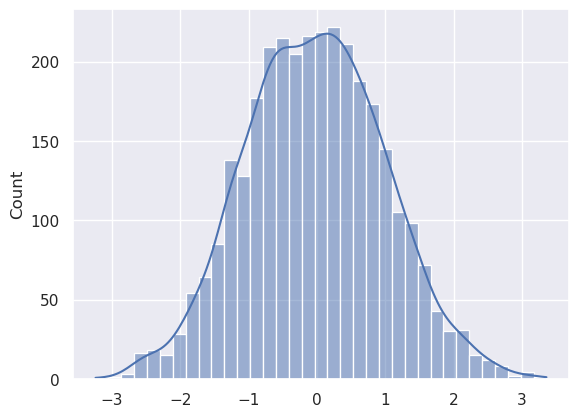

In [18]:
normal_sample = normal_dist.rvs(size = df.shape[0])
sns.set()
sns.histplot(normal_sample, kde = True)

The distribution of our normal sample looks similar to what we are expected. Now see about how QQ plot compares 2 distribution

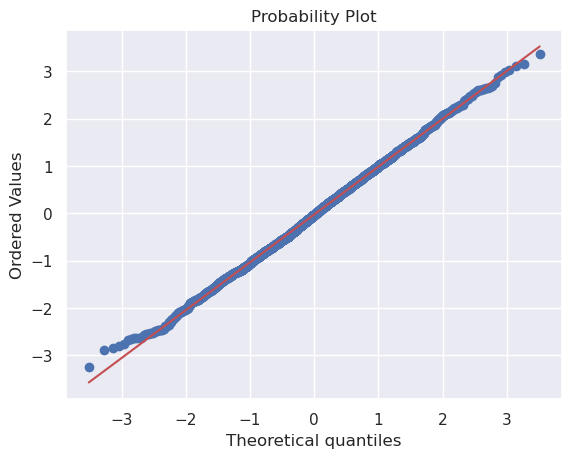

In [19]:
stats.probplot(normal_sample, dist = 'norm', plot = plt)
plt.show()

## Systolic blood pressure `sbp0` distribution

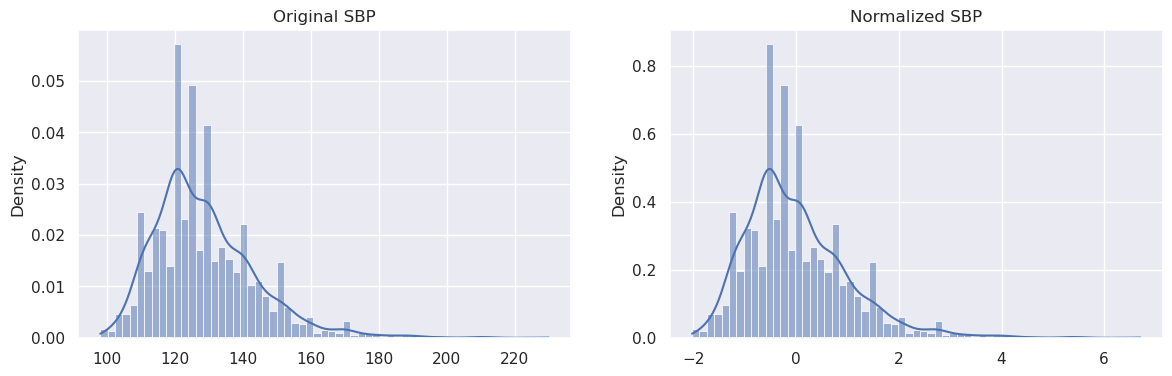

In [20]:
sbp = df['sbp0'].values

f, axs = plt.subplots(ncols = 2, figsize = (14, 4))
sns.histplot(sbp, stat = 'density', kde = True, ax = axs[0])
axs[0].set_title("Original SBP")
sns.histplot(standardize(sbp), stat = 'density', kde = True, ax= axs[1])
axs[1].set_title("Normalized SBP")
plt.show()

[]

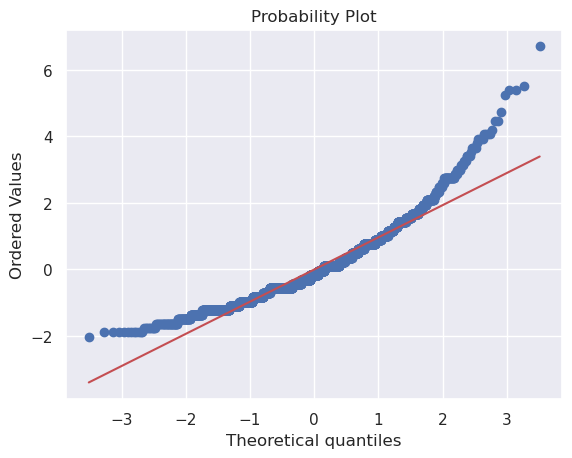

In [21]:
stats.probplot(standardize(sbp), dist = 'norm', plot = plt)
plt.plot()

In [22]:
sbp_mean = np.mean(sbp)
print(f"Mean of sbp: {sbp_mean}")

Mean of sbp: 128.62690355329948


In [23]:
sbp_std = np.std(sbp)
print(f"Standard deviation of sbp: {sbp_std}")

Standard deviation of sbp: 15.118202195371634


## Diastolic blood pressure `dbp0` distribution

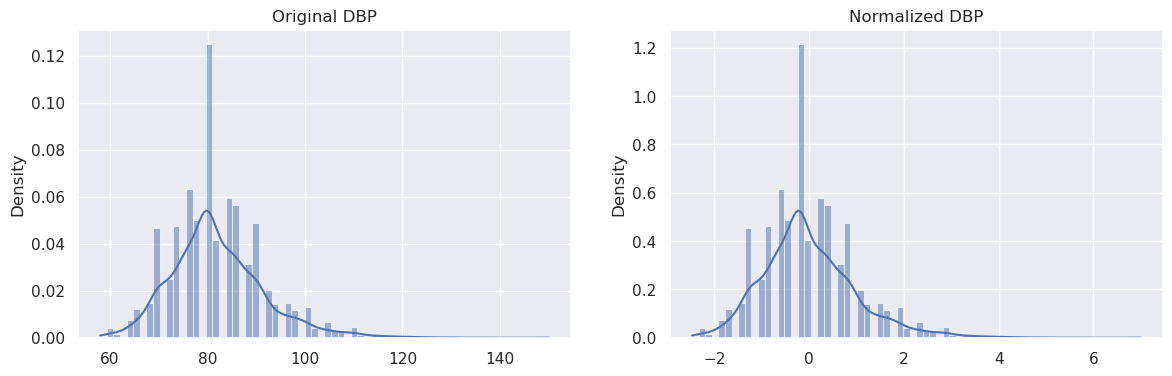

In [24]:
dbp = df['dbp0'].values

f, axs = plt.subplots(ncols = 2, figsize = (14, 4))
sns.histplot(dbp, stat = 'density', kde = True, ax = axs[0])
axs[0].set_title("Original DBP")
sns.histplot(standardize(dbp), stat = 'density', kde = True, ax= axs[1])
axs[1].set_title("Normalized DBP")
plt.show()

[]

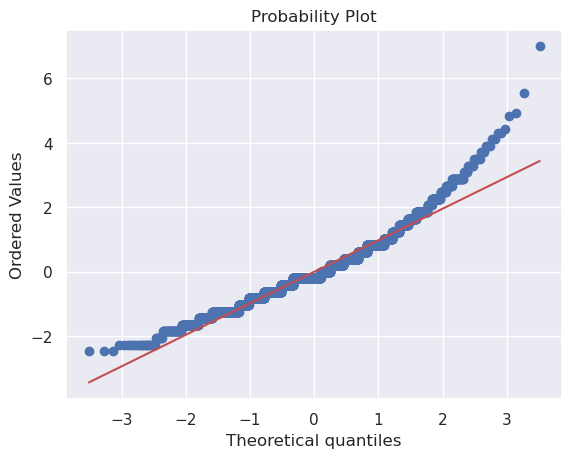

In [25]:
stats.probplot(standardize(dbp), dist = 'norm', plot = plt)
plt.plot()

In [26]:
dbp_mean = np.mean(dbp)
dbp_std = np.std(dbp)

print("DBP Mean: " + str(dbp_mean))
print("DBP Std: " + str(dbp_std))

DBP Mean: 82.00793147208122
DBP Std: 9.723604151799254


## Cholesterol level `Chol0` distribution

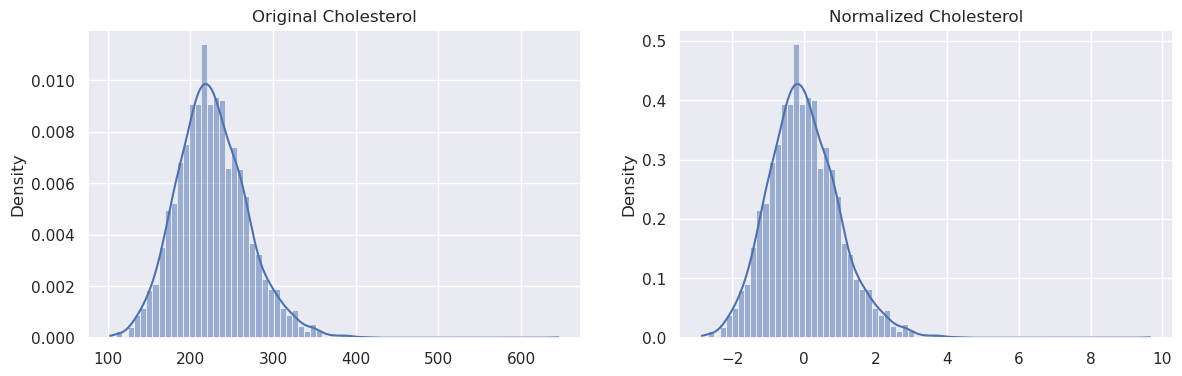

In [27]:
chol = df['chol0'].values

f, axs = plt.subplots(ncols = 2, figsize = (14, 4))
sns.histplot(chol, stat = 'density', kde = True, ax = axs[0])
axs[0].set_title("Original Cholesterol")
sns.histplot(standardize(chol), stat = 'density', kde = True, ax= axs[1])
axs[1].set_title("Normalized Cholesterol")
plt.show()

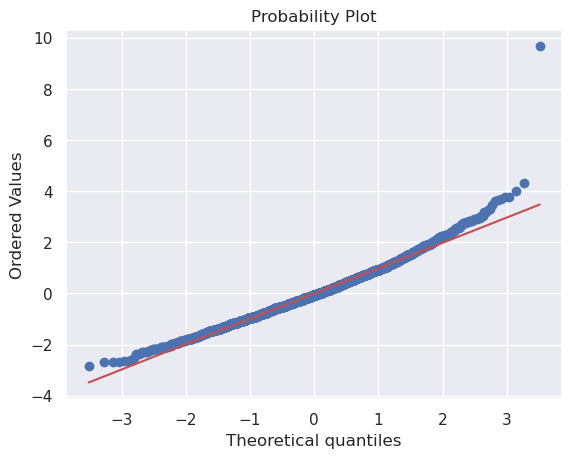

In [28]:
stats.probplot(standardize(chol), dist= 'norm', plot = plt)
plt.show()

##  Kolmogorov-Smirnov Test

The Kolmogorov–Smirnov statistic quantifies a distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution, or between the empirical distribution functions of two samples.

The KS Test is used to decide if a sample comes from a population with a specific distribution. It is based on the empirical distribution function (ECDF). Given $N$ ordered data points $Y_1, Y_2,..., Y_N$ the ECDF is defined by:

$$E_N = n(i) / N$$

where n(i) is the number of point less than $Y_i$ and $Y_i$ are ordered from smallest to largest value.

The test statistic of KS Test is:

$$D = \max_{1 \leq i \leq N} \bigg(F(Y_i) - \frac{i-1}{N}, \frac{i}{N} - F(Y_i)\bigg)$$

Given a significance level $\alpha$ (usually 0.05) and its corresponding critical value, we can statistically determine about the hypothesis whether the sample follows a specific distribution or not

In [29]:
def visualize_ks(sample, expected_distribution, name):
    sample = np.sort(sample)
    expected = np.sort(expected_distribution)
    F_sample = np.zeros(sample.shape)
    F_expected = np.zeros(expected.shape)
    
    for i in range(sample.size):
        s = sample[i]
        ns = sample[sample < s].size
        F_sample[i] = ns
    
    for i in range(expected.size):
        e = expected[i]
        ne = expected[expected < e].size
        F_expected[i] = ne
        
    plt.plot(sample, F_sample)
    plt.plot(expected, F_expected)
    plt.title(name + " KS Test")
    plt.legend(labels = ['Normalized' + name, 'Normal Sample'])

### `SBP` KS Test

In [30]:
stats.kstest(standardize(sbp), stats.norm.cdf)

KstestResult(statistic=0.11324513146948256, pvalue=1.1458893876753721e-35, statistic_location=0.09082405625722363, statistic_sign=1)

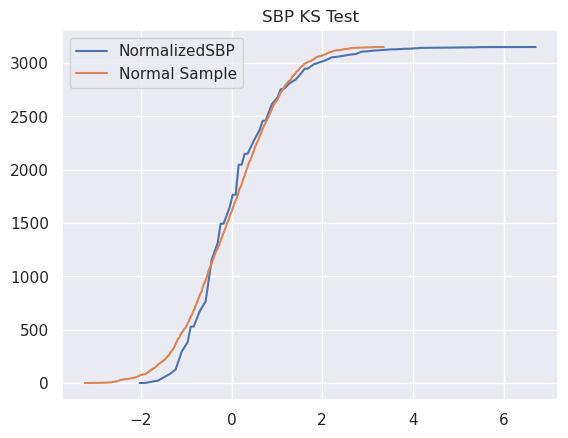

In [31]:
visualize_ks(standardize(sbp), normal_sample, 'SBP')

*__Comments:__*

- As seen in the KS test, the p-value = $1.14*10^{-35}$ whihc is small the significance level $0.05$, we reject the null hypothesis $H_0:$ the sample follows normal distribution.

### `DBP` KS Test

In [32]:
stats.kstest(standardize(dbp), stats.norm.cdf)

KstestResult(statistic=0.12082295003242915, pvalue=1.48338556057475e-40, statistic_location=-0.20650074198152932, statistic_sign=1)

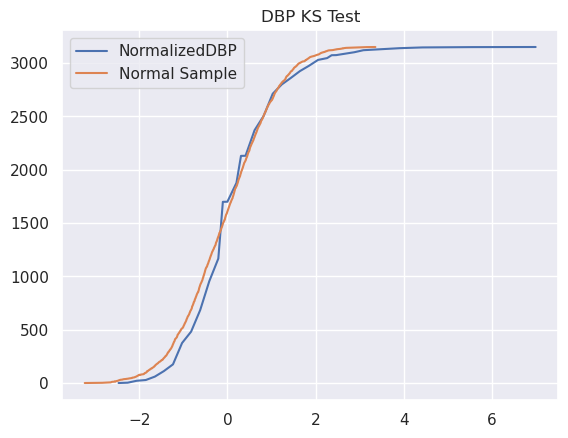

In [33]:
visualize_ks(standardize(dbp), normal_sample, 'DBP')

### `Chol0` KS Test

In [34]:
stats.kstest(standardize(chol), stats.norm.cdf)

KstestResult(statistic=0.038593245495764705, pvalue=0.00016256029282242252, statistic_location=0.15357111664736822, statistic_sign=1)

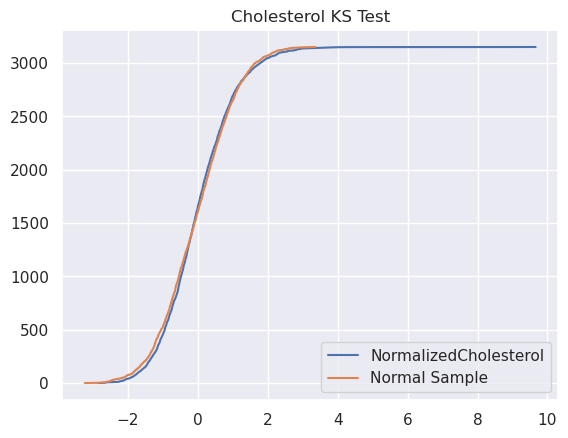

In [35]:
visualize_ks(standardize(chol), normal_sample, 'Cholesterol')

## Outliers detection

<Axes: >

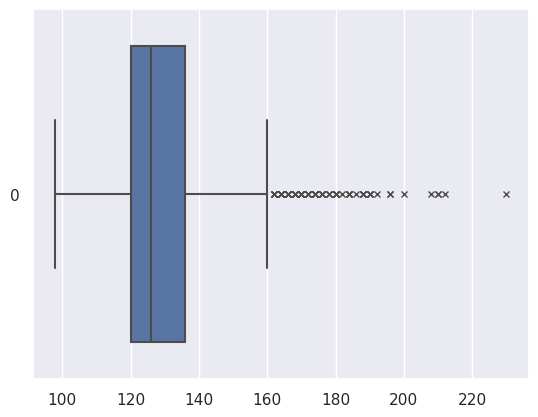

In [36]:
sns.boxplot(sbp, flierprops={"marker": "x"}, orient = 'h')

In [37]:
# sort and see the out-of-range data points
def min_max_range(x):
    x = np.sort(x)
    q1 = np.quantile(x, 0.25)
    q3 = np.quantile(x, 0.75)
    iqr =  q3 - q1
    return (q1 - 1.5*iqr), (q3 + 1.5*iqr)

In [38]:
lbSBP, ubSBP = min_max_range(sbp)
print(f"Min value in range: {lbSBP}")
print(f"Max value in range: {ubSBP}")
print(f"Min value in sample: {sbp.min()}")
print(f"Max value in sample: {sbp.max()}")

Min value in range: 96.0
Max value in range: 160.0
Min value in sample: 98
Max value in sample: 230


In [39]:
# Total outliers detected
print(f"Outliers take {round(sbp[sbp > ubSBP].size*100 / sbp.size, 2)}% to the right and {sbp[sbp < lbSBP].size*100 / sbp.size}% to the left")

Outliers take 3.11% to the right and 0.0% to the left


<Axes: >

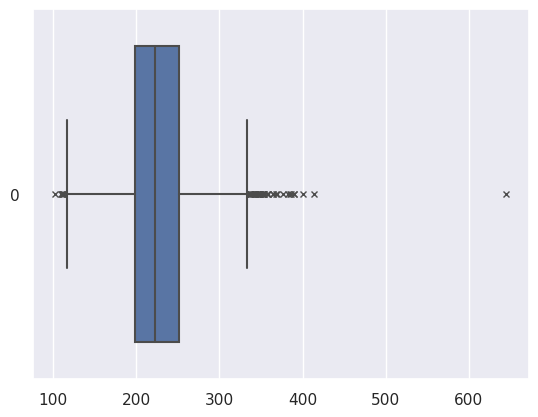

In [40]:
sns.boxplot(chol, flierprops={"marker": "x"}, orient = 'h')

In [41]:
lbChol, ubChol = min_max_range(chol)
print(f"Min value in range: {lbChol}")
print(f"Max value in range: {ubChol}")
print(f"Min value in sample: {chol.min()}")
print(f"Max value in sample: {chol.max()}")

Min value in range: 117.0
Max value in range: 333.0
Min value in sample: 103.0
Max value in sample: 645.0


In [42]:
# Total outliers detected
print(f"Outliers take {round(chol[chol > ubChol].size*100 / chol.size, 2)}% to the right and {round(chol[chol < lbChol].size*100 / chol.size, 2)}% to the left")

Outliers take 1.43% to the right and 0.22% to the left


*__Comments:__*
- Cholesterol level seems to get closer to normality comparing two other similar features such as DBP or SBP. This assumption is somewhat confirmed through the p-value of KS test (approximately 0.00016) which indicates the lower confidence if we reject the null hypothesis.
- About 1.5% of Cholesterol data might be considered as outliers which takes a small proportion and can be removed. This is followed by forcing Cholesterol distribution to mostly Gaussian distribution. 
- With this interesting discovery, we are now able to draw a sample from Gaussian distribution instead of true distribution to add some randomness and diversity into our data for future models

# Linearity and Correlation

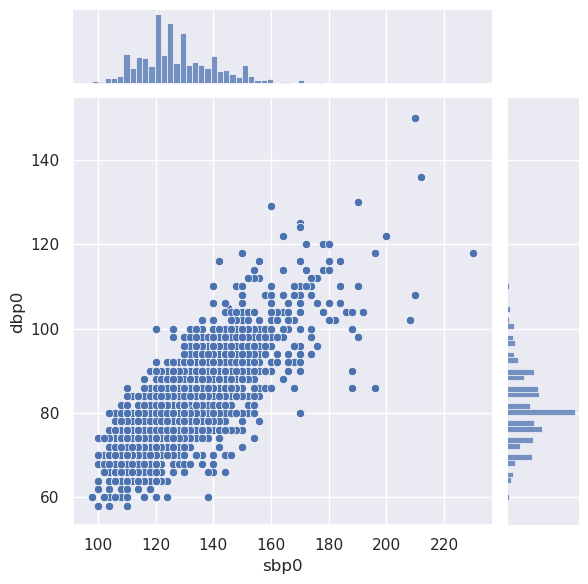

In [43]:
# Joint plot between diastolic and systolic
sns.jointplot(data = df, x = "sbp0", y = 'dbp0')

In here, from the medical view, systolic blood pressure and diastolic blood pressure are directly correlated and have impact on each other since they are 2 factors to assess the heart health. As we seen in the above scatter plot, they seems to have some kind of significant linear correlation. Althout it is not obvious but most of our subjects are likely not to suffer from hypertension (their blood pressure distributions are around the healthy blood rate)

It seems to have some outlier in the larger side in `sbp`

## Linear Models

In [44]:
df.columns

Index(['id', 'age0', 'height0', 'weight0', 'sbp0', 'dbp0', 'chol0', 'behpat0',
       'ncigs0', 'dibpat0', 'chd69', 'typechd', 'time169', 'arcus0'],
      dtype='object')

In [45]:
num_columns = ['age0', 'height0', 'weight0', 'sbp0', 'dbp0', 'chol0','ncigs0', 'time169']
cate_columns = ['behpat0', 'dibpat0', 'chd69', 'typechd','arcus0']

In [46]:
corr = df[num_columns].corr(numeric_only = True)
corr

,age0,height0,weight0,sbp0,dbp0,chol0,ncigs0,time169
age0,1.000000,-0.095666,-0.034205,0.165963,0.139494,0.089072,-0.005506,-0.072380
height0,-0.095666,1.000000,0.533166,0.017976,0.009468,-0.089219,0.015019,-0.008890
weight0,-0.034205,0.533166,1.000000,0.253253,0.296016,0.008483,-0.081665,-0.065182
sbp0,0.165963,0.017976,0.253253,1.000000,0.772886,0.121959,0.030129,-0.107256
dbp0,0.139494,0.009468,0.296016,0.772886,1.000000,0.127478,-0.059113,-0.109345
chol0,0.089072,-0.089219,0.008483,0.121959,0.127478,1.000000,0.095905,-0.094348
ncigs0,-0.005506,0.015019,-0.081665,0.030129,-0.059113,0.095905,1.000000,-0.094935
time169,-0.072380,-0.008890,-0.065182,-0.107256,-0.109345,-0.094348,-0.094935,1.000000


<Axes: >

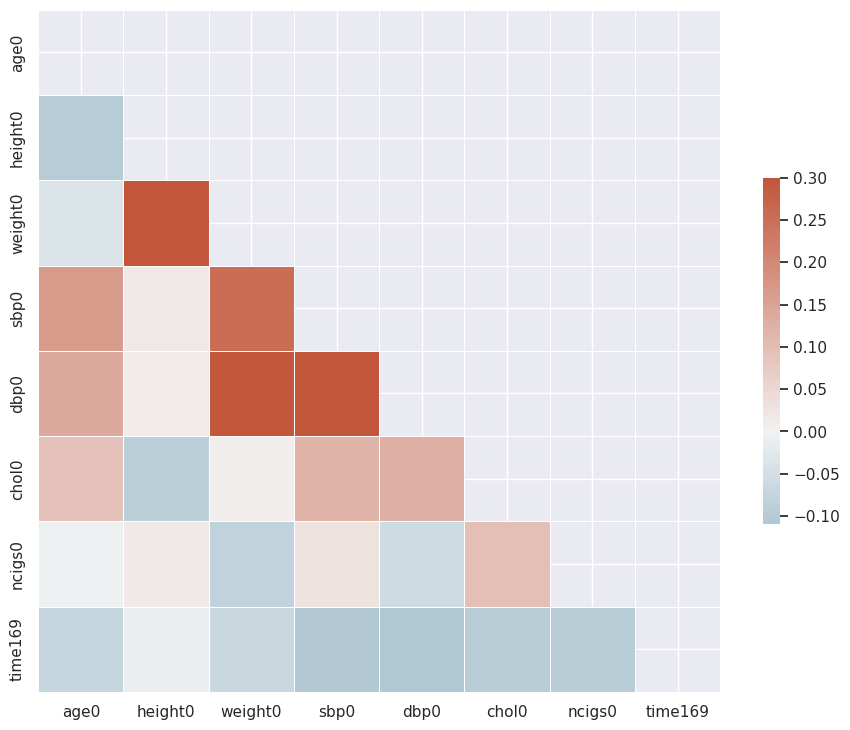

In [47]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the above figure, we have some assumptions:
- `sbp` sligtly dependent on `age0` and `weight0`
- `dbp0` significantly depends on `age0`,`weight0` and `sbp0`
- `weight0` and `height0` strongly depends on each other with large positive correlation

#### Recheck the linearity on `weight0` and `height0`

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# weight and height features
weight = df['weight0'].values
height = df['height0'].values

#fit polynomial regression model
reg = LinearRegression()
reg.fit(weight.reshape(-1,1), height.reshape(-1, 1))

#display model coefficients
print(reg.intercept_, reg.coef_)

[149.6524118] [[0.35742738]]


In [49]:
height_pred = reg.predict(weight.reshape(-1, 1))

print(f"R2 Score:")
r2_score(height, height_pred)

R2 Score:


0.2842661949760502

*__Comment:__*

- R2 score is surprisingly low in spite of its significant Pearson correlation (0.533) as mentioned in above matrix. The reason might be `height0` not only depends on `weight0` but also other hidden variables. 
- The correlation of `weight0` might be the highest out of all variables but it is not enough to explain the model statistically.

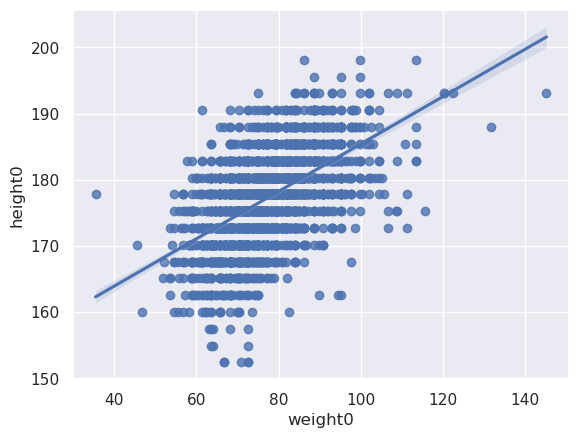

In [50]:
sns.regplot(x = 'weight0', y = 'height0', data = df)
plt.show()

#### Linear regression fits `dbp0` on `age0`, `weight0` and `sbp0`

In [51]:
x = df[['age0', 'weight0', 'sbp0']].values
y = df['dbp0'].values

In [52]:
#fit polynomial regression model
reg = LinearRegression()
reg.fit(x, y)

#display model coefficients
print(reg.intercept_, reg.coef_)

10.465992963918595 [0.03534324 0.11043304 0.47723627]


In [53]:
y_pred = reg.predict(x)
print("R2 Score")
r2_score(y, y_pred)

R2 Score


0.6084870526955136

*__Comment:__*

1. From the coefficient in linear model, the `age0` attribute contributes less than remainig attributes, and `sbp0` contribute the most out of three features. This observation is suitable with our observation about correlation
2. *__R2 score__* approximately being 0.61 indicates that the linear model has pretty high correlation

## Coronary Heart Disease correlation with some variables

In [54]:
df.head()

,id,age0,height0,weight0,sbp0,dbp0,chol0,behpat0,ncigs0,dibpat0,chd69,typechd,time169,arcus0
0,2001,49,185.42,68.10,110,76,225.0,2,25,1,0,0,1664,0.0
1,2002,42,177.80,72.64,154,84,177.0,2,20,1,0,0,3071,1.0
2,2003,42,175.26,72.64,110,78,181.0,3,0,0,0,0,3071,0.0
3,2004,41,172.72,69.01,124,78,132.0,4,20,0,0,0,3064,0.0
4,2005,59,177.80,68.10,144,86,255.0,3,20,0,1,1,1885,1.0


Out of 1501 smokers, there are 10.53 % CHD. 
Otherwise, out of 1651 non-smokers, there are only 5.88% CHD


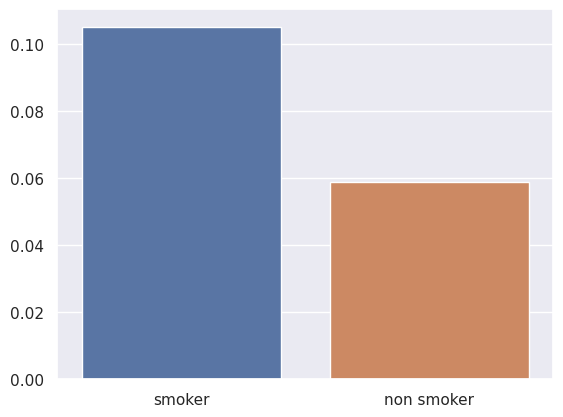

In [55]:
# How many percent of smokers suffering from CHD

smokers = df[df["ncigs0"] > 0]
nonsmokers = df[df["ncigs0"] == 0]

chd_sm = smokers[smokers["chd69"] == 1]
chd_nsm = nonsmokers[nonsmokers['chd69'] == 1]

per_sm = chd_sm.shape[0] / smokers.shape[0] # percent chd in smokers
per_nsm =  chd_nsm.shape[0] / nonsmokers.shape[0] # percent chd in non smokers

print(f"Out of {smokers.shape[0]} smokers, there are {round(per_sm*100,2)} % CHD. \nOtherwise, out of {nonsmokers.shape[0]} non-smokers, there are only {round(per_nsm*100, 2)}% CHD")

sns.barplot(x = ["smoker", 'non smoker'], y = [per_sm, per_nsm])
plt.show()

*__Comment:__*
- Unexpectedly, the number of smokers (who smoke at least one cigarette per day) and number of non smokers are similar (1502 versus 1652). However, back to the day in which the WCGS dataset is collected in Western, it is explainable due to their smoking culture
- Also, as I expected before, smoking people seems to have a double rate of getting CHD disease comparing to non smoker (approximately 11% and 5.9%)

CHD event grouped by 3 states of blood pressure: $\geq 140, (90, 140)$ corresponding to hypertension, hypotension, healthy state

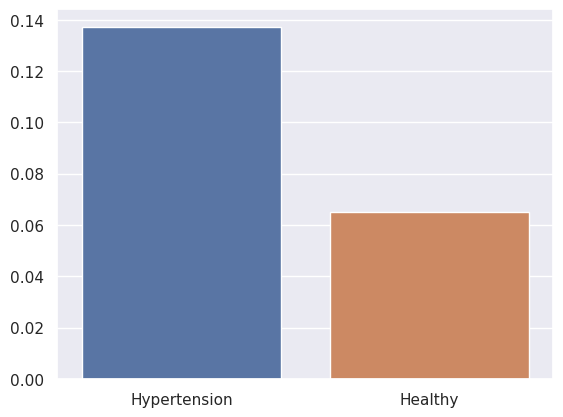

In [56]:
hyper = df[df["sbp0"] >= 140]
healthy = df[(df["sbp0"] < 140) & (90 < df["sbp0"])]

chd_hyper = hyper[hyper.chd69 == 1]
chd_hea = healthy[healthy.chd69 == 1]

per_hyper = chd_hyper.shape[0] / hyper.shape[0]
per_hea = chd_hea.shape[0] / healthy.shape[0]

sns.barplot(x = ["Hypertension","Healthy"], y = [per_hyper, per_hea])
plt.show()

*__Comment:__*

- From the figure above, hypertension seems to be one of the factors which might lead to the increases in CHD probabiliy (just under 14% and about 7%)

# Hypothesis Testing

In [57]:
df.columns

Index(['id', 'age0', 'height0', 'weight0', 'sbp0', 'dbp0', 'chol0', 'behpat0',
       'ncigs0', 'dibpat0', 'chd69', 'typechd', 'time169', 'arcus0'],
      dtype='object')

In [58]:
df['bp_ratio'] = df['sbp0'] / df['dbp0']

In [59]:
x = df.drop(['chd69', 'id'], axis = 1)
x_labels = x.columns
x = x.values
y = df['chd69'].values
reg = LinearRegression()

reg.fit(x, y)
regstats.summary(reg, x, y, x_labels)

Residuals:
    Min      1Q  Median     3Q    Max
-0.0422 -0.0026  0.0109 0.0314 1.5218


Coefficients:
            Estimate  Std. Error   t value   p value
_intercept -0.195416    0.178372   -1.0956  0.273358
age0        0.000351    0.000364    0.9648  0.334713
height0     0.000753    0.000144    5.2214  0.000000
weight0    -0.000277    0.000245   -1.1288  0.259055
sbp0       -0.000503    0.000190   -2.6494  0.008103
dbp0        0.001008    0.000346    2.9165  0.003565
chol0       0.000252    0.000042    6.0481  0.000000
behpat0     0.010246    0.004086    2.5076  0.012206
ncigs0      0.000397    0.000145    2.7424  0.006134
dibpat0     0.018785    0.007680    2.4459  0.014502
typechd     0.454059    0.004527  100.3064  0.000000
time169    -0.000042    0.000001  -39.0629  0.000000
arcus0      0.009218    0.004632    1.9902  0.046654
bp_ratio    0.051060    0.081395    0.6273  0.530498
---
R-squared:  0.81880,    Adjusted R-squared:  0.81805
F-statistic: 1090.73 on 13 features


In [60]:
reg.intercept_

-0.19541558232741463

*__Comments:__*
- Except for `age0` and `bp_ratio` features, most of features have P-value less than our significance level, here I choose popular $\alpha = 0.05$. This indicates that we have strong statistical evidence enough to confirm the effect of those features on population. For `bp_ration` case, high P-value can be explained that this feature combine information from `sbp` and `dbp` which causes multicollinearity
- Adjusted R2 score is considered to be good for quick and simple predictive model such as linear regression.

# Predictive model

## 1. Logisic Regression

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [62]:
x = df.drop(['chd69', 'id'], axis = 1)
y = df.chd69

x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 0)
lr = LinearRegression().fit(x_train,y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print(f"Mean accuracy on training set: {lr.score(x_train, y_train)}")
print(f"Mean accuracy on test set: {lr.score(x_test,y_test)}")

Mean accuracy on training set: 0.8139321754721223
Mean accuracy on test set: 0.8298314323643051


So very simple logistic regression model captures pretty great information about the data with acceptable accuracy in test set. However, I want to modify the parameter a little bit and expect increases in performance

In [63]:
x = df.drop(['chd69', 'id'], axis = 1)
y = df.chd69

poly = PolynomialFeatures(2)
x = poly.fit_transform(x)

x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 0)\

lr = LinearRegression().fit(x_train,y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print(f"Mean accuracy on training set: {lr.score(x_train, y_train)}")
print(f"Mean accuracy on test set: {lr.score(x_test,y_test)}")

Mean accuracy on training set: 0.9837090880016326
Mean accuracy on test set: 0.977474157891069
